<a href="https://colab.research.google.com/github/Tommy-Gozali/demand-forecast/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast

import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from google.colab import drive

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
pd.options.plotting.backend = "plotly"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data_science_portfolio/power_load_forecast/
df = pd.read_csv("power_load_BE_elia_15M_2015_2024.csv", delimiter = ";", on_bad_lines="skip")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data_science_portfolio/power_load_forecast


In [ ]:
%run utils.ipynb

In [ ]:
clean_start_date = "2021-11-01"
clean_end_date   = "2023-06-23"
hour_in_week     = 24*7
cleaning_service = DataCleaningService()
df_clean = cleaning_service.normalize_data(df = df,
                                          start_date = clean_start_date,
                                          end_date   = clean_end_date)
                                          #offset_rolling_feature_in_h = hour_in_week )

In [ ]:
cleaning_service.check_missing_date(df = df_clean)

no missing dates detected!


In [ ]:
%run create_experiment.ipynb

In [ ]:
experiment = CreateExperiment(data = df_clean,
                              frequency_magnitude_input = 15,
                              frequency_unit_input = "m", #m = minutes, H = hour
                              frequency_magnitude_output = 1,
                              frequency_unit_output = "H", #m = minutes, H = hour
                              forecast_type = "day_ahead",
                              train_size = 0.7)

In [ ]:
duration_in_day, duration_in_week, duration_in_month = experiment.basic_durations

In [ ]:
train_indexes, val_indexes, test_indexes = experiment.create_train_test_validation_split_round()

In [ ]:
steps = experiment.steps

In [ ]:
df_clean = experiment.get_input_data()

In [ ]:
def scatter_chart(df, color, name):
  trace = go.Scatter(
            x = df.index,
            y = df[y],
            name=name,
            marker=dict(
                  color=color,
                  line=dict(
                  color=color)
                ),
            )
  return trace

In [ ]:
import plotly.graph_objs as go
from plotly import subplots

y = "Total Load"
trace1 = scatter_chart(df_clean.loc[train_indexes], 'rgb(128, 0, 128)', "train")
trace2 = scatter_chart(df_clean.loc[val_indexes], 'rgba(50, 171, 96, 0.6)', "test")
trace3 = scatter_chart(df_clean.loc[test_indexes], 'rgba(0, 100, 50, 0.6)', "val")

fig = subplots.make_subplots(rows=1,cols=1, vertical_spacing=0.5)
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.show()

In [ ]:
%run utils.ipynb

In [ ]:
fe = FeatureEngineering()

In [ ]:
data = df_clean.rename(columns = {"Total Load":"y"})
data[["month", "dayofweek", "hour"]] = fe.get_basic_temporal_features(df=data)

In [ ]:
print(f"Train dates : {train_indexes.min()} --- {train_indexes.max()}  (n={len(train_indexes)})")
print(f"Test dates  : {val_indexes.min()} --- {val_indexes.max()}  (n={len(val_indexes)})")
print(f"Val dates   : {test_indexes.min()} --- {test_indexes.max()}  (n={len(test_indexes)})")


Train dates : 2021-11-01 00:00:00+00:00 --- 2022-12-25 23:00:00+00:00  (n=10080)
Test dates  : 2022-12-26 00:00:00+00:00 --- 2023-03-25 23:00:00+00:00  (n=2160)
Val dates   : 2023-03-26 00:00:00+00:00 --- 2023-06-23 23:00:00+00:00  (n=2160)


In [ ]:
%run get_exog_data.ipynb

In [ ]:
brussel_longitude = 50.85
brussel_latitude  = 4.34
brussel_weather_data = OpenMeteoApi(brussel_longitude,
                                    brussel_latitude)
def get_start_end_date(date_list: list):
  return str(date_list[0])[:10], str(date_list[-1])[:10]

start_date_train, end_date_train = get_start_end_date(train_indexes)
start_date_val,  end_date_val    = get_start_end_date(val_indexes)
start_date_test,  end_date_test  = get_start_end_date(test_indexes)

In [ ]:
exog_wea_parameters = ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "is_day"]

parameters_train = brussel_weather_data.initiate_parameters(start_date = start_date_train,
                                                            end_date = end_date_train,
                                                            parameters = exog_wea_parameters)
parameters_test = brussel_weather_data.initiate_parameters(start_date = start_date_test,
                                                            end_date = end_date_test,
                                                            parameters = exog_wea_parameters)
parameters_val = brussel_weather_data.initiate_parameters(start_date = start_date_val,
                                                            end_date = end_date_val,
                                                            parameters = exog_wea_parameters)

data[exog_wea_parameters] = brussel_weather_data.get_historical_actual_data(parameters_train)\
                            .combine_first(brussel_weather_data.get_historical_forecast_data(parameters_val))\
                            .combine_first(brussel_weather_data.get_historical_forecast_data(parameters_test))

In [ ]:
%run utils.ipynb

In [ ]:
import itertools

day = 1
day_in_week = 7
duration_list   = [day, day_in_week]
agg_method_list = ['mean', 'max', 'min']

duration_agg_method_combinations = list(itertools.product(duration_list, agg_method_list))

In [ ]:
rolling_feature_df_list = []
for element in duration_agg_method_combinations:
  data_exog_rolled = fe.get_rolling_data(df = data,
                                         parameter = "temperature_2m",
                                         duration  = element[0],
                                         duration_unit = "D",
                                         agg_method = element[1])
  rolling_feature_df_list.append(data_exog_rolled)

data_exog_rolled = pd.concat(rolling_feature_df_list, axis = 1)
data = pd.concat([data,data_exog_rolled], axis = 1)
rolled_parameters = data_exog_rolled.columns.tolist()
#data = data.dropna()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

In [ ]:
poly_cols = ['temperature_2m','relative_humidity_2m', 'dew_point_2m',
             'apparent_temperature', 'temperature_2m_rolling_mean_1_D', 'temperature_2m_rolling_mean_7_D']
poly_features = transformer_poly.fit_transform(data[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
#data[poly_features.columns] = poly_features

In [ ]:
data_train = data.loc[train_indexes].dropna() #TO DELETE MISSING ROWS DUE TO ROLLED PARAMETERS
data_val   = data.loc[val_indexes]
data_test  = data.loc[test_indexes]

In [ ]:
for dataset in [data_train, data_val, data_test]:
  if dataset.isna().sum().sum() > 0:
    print("Missing data!!")

In [ ]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from skforecast.model_selection import bayesian_search_forecaster
from sklearn.metrics import mean_squared_error

In [ ]:
data_train_val = pd.concat([data_train, data_val])

In [ ]:
exog_parameters = exog_wea_parameters + rolled_parameters
exog_vars = ["month", "dayofweek", "hour"] + exog_parameters

In [ ]:
# Lags used as predictors
lags_grid = [duration_in_day, duration_in_week, duration_in_month]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'     : trial.suggest_int('n_estimators', 80, 100),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'     : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }
    return search_space

results, frozen_trial = bayesian_search_forecaster(
                            forecaster            = forecaster,
                            y                     = data_train_val['y'],
                            exog                  = data_train_val[exog_vars],
                            lags_grid             = lags_grid,
                            search_space          = search_space,
                            steps                 = duration_in_week,
                            metric                = ['mean_absolute_percentage_error','mean_squared_error'],
                            refit                 = True,
                            initial_train_size    = len(train_indexes),
                            fixed_train_size      = False,
                            n_trials              = 10,
                            random_state          = 123,
                            return_best           = False,
                            n_jobs                = 'auto',
                            verbose               = True,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {},
                            gap  = duration_in_week
                        )

NameError: name 'forecaster' is not defined

In [ ]:
results.loc[20].params

{'n_estimators': 94, 'min_samples_leaf': 3, 'max_features': 'sqrt'}

In [ ]:
# Backtesting
# ==============================================================================
regressor  = RandomForestRegressor(n_estimators=94, min_samples_leaf=3, max_features="sqrt")
regressor_name = str(regressor).split('()')[0]
forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags      = duration_in_month
             )

results, predictions = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = data['y'],
                            exog                  = data[exog_vars],
                            steps                 = duration_in_week,
                            metric                = ['mean_absolute_percentage_error','mean_squared_error'],
                            refit                 = True,
                            initial_train_size    = len(data_train_val.index),
                            fixed_train_size      = False,
                            random_state          = 123,
                            n_jobs                = 'auto',
                            verbose               = True,
                            show_progress         = True,
                            gap  = duration_in_week
                      )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12073
Number of observations used for backtesting: 2327
    Number of folds: 13
    Number of steps per fold: 168
    Number of steps to exclude from the end of each train set before test (gap): 168
    Last fold only includes 143 observations.

Fold: 0
    Training:   2021-11-01 00:00:00+00:00 -- 2023-03-19 00:00:00+00:00  (n=12073)
    Validation: 2023-03-26 01:00:00+00:00 -- 2023-04-02 00:00:00+00:00  (n=168)
Fold: 1
    Training:   2021-11-01 00:00:00+00:00 -- 2023-03-26 00:00:00+00:00  (n=12241)
    Validation: 2023-04-02 01:00:00+00:00 -- 2023-04-09 00:00:00+00:00  (n=168)
Fold: 2
    Training:   2021-11-01 00:00:00+00:00 -- 2023-04-02 00:00:00+00:00  (n=12409)
    Validation: 2023-04-09 01:00:00+00:00 -- 2023-04-16 00:00:00+00:00  (n=168)
Fold: 3
    Training:   2021-11-01 00:00:00+00:00 -- 2023-04-09 00:00:00+00:00  (n=12577)
    Validation: 2023-04-16 01:00:0

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
results

[0.04605760592563487, 281285.7984246388]

In [ ]:
ind = predictions.index[166]
predictions.loc[ind]

pred    8134.204263
Name: 2023-04-01 23:00:00+00:00, dtype: float64

In [ ]:
ind = predictions.index[168:]
predictions.loc[ind]

,pred
2023-04-02 01:00:00+00:00,7745.688336
2023-04-02 02:00:00+00:00,7569.250243
2023-04-02 03:00:00+00:00,7480.998549
2023-04-02 04:00:00+00:00,7641.133508
2023-04-02 05:00:00+00:00,7943.984412
...,...
2023-06-23 19:00:00+00:00,8394.765939
2023-06-23 20:00:00+00:00,8258.667598
2023-06-23 21:00:00+00:00,7891.369037
2023-06-23 22:00:00+00:00,7507.588004


In [ ]:

data_test[regressor_name] = np.nan
data_test[regressor_name].loc[predictions.index] = predictions.pred

In [ ]:
data_test

,y,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,month,dayofweek,...,dew_point_2m,apparent_temperature,is_day,temperature_2m_rolling_mean_1_D,temperature_2m_rolling_max_1_D,temperature_2m_rolling_min_1_D,temperature_2m_rolling_mean_7_D,temperature_2m_rolling_max_7_D,temperature_2m_rolling_min_7_D,"RandomForestRegressor(max_features='sqrt', min_samples_leaf=3, n_estimators=94)"
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-26 00:00:00+00:00,7684.9375,7962.0925,7824.9825,8099.1975,7865.3375,7727.5850,8003.0925,7671.9025,3,6,...,23.3,31.6,0,28.529167,29.1,28.1,28.349405,29.1,27.0,NaN
2023-03-26 01:00:00+00:00,7444.9200,7614.2400,7477.1300,7751.3525,7553.3100,7415.5550,7691.0625,7450.5225,3,6,...,23.5,31.8,0,28.525000,29.1,28.0,28.355357,29.1,27.1,7560.346290
2023-03-26 02:00:00+00:00,7369.7775,7609.4750,7471.3850,7747.5700,7590.3950,7451.6450,7729.1350,7467.1700,3,6,...,23.6,32.0,0,28.520833,29.1,28.0,28.360714,29.1,27.2,7387.773288
2023-03-26 03:00:00+00:00,7342.6050,7521.0425,7383.9325,7658.1525,7526.3475,7388.5925,7664.1050,7412.5325,3,6,...,23.7,31.7,1,28.508333,29.1,27.9,28.364881,29.1,27.2,7366.882734
2023-03-26 04:00:00+00:00,7651.9500,7711.1100,7574.0000,7848.2225,7734.1175,7596.3625,7871.8725,7589.8050,3,6,...,23.8,31.5,1,28.483333,29.1,27.8,28.368452,29.1,27.2,7503.238380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23 19:00:00+00:00,8545.1650,8506.1400,8161.9675,8850.3150,8698.2800,8365.1075,9031.4525,8671.2875,6,4,...,23.2,27.8,0,27.641667,28.1,26.9,27.848810,28.6,26.9,8394.765939
2023-06-23 20:00:00+00:00,8602.2100,8631.7800,8287.6075,8975.9525,8683.9825,8350.8075,9017.1525,8738.6000,6,4,...,23.2,27.8,0,27.641667,28.1,26.9,27.844643,28.6,26.9,8258.667598
2023-06-23 21:00:00+00:00,8177.4650,8375.1650,8030.9900,8719.3350,8362.1150,8028.9400,8695.2825,8418.7325,6,4,...,23.2,27.9,0,27.645833,28.1,26.9,27.840476,28.6,26.9,7891.369037


In [ ]:
fig = data_test.loc["2023-04-02 01:00:00+00:00":"2023-04-16 01:00:00+00:00"][["y", "Most recent forecast", regressor_name, "Week-ahead forecast"]].plot.line()
fig.show()

In [ ]:
def get_backtest_folds_periods(y: pd.Series,
                              steps: int,
                              initial_train_size: int,
                              ) -> pd.DataFrame:

  start_date_first_fold = y.index[initial_train_size:][0]

  n_folds = len(y.index[initial_train_size:])/hour_in_week
  n_folds = n_folds - 1 #NOT GET ALL FOLDS

  fold_df = pd.DataFrame(columns=["fold_start_date", "fold_end_date"])

  for fold_number in range(int(n_folds)):

    if fold_number == 0:
      start_date_fold = start_date_first_fold

    else:
      start_date_fold = end_date_fold + pd.Timedelta(1, "H")

    end_date_fold   = start_date_fold + pd.Timedelta(hour_in_week - 1, "H")

    fold_df.loc[fold_number] = [start_date_fold, end_date_fold]
    fold_df.index.anmes = ["fold_number"]

  return fold_df

In [ ]:
df_backtest_fold_periods = get_backtest_folds_periods(y = data,
                                                      steps = duration_in_week,
                                                      initial_train_size = len(data_train_val.index))

In [ ]:
df_backtest_fold_periods

,fold_start_date,fold_end_date
0,2023-03-19 01:00:00+00:00,2023-03-26 00:00:00+00:00
1,2023-03-26 01:00:00+00:00,2023-04-02 00:00:00+00:00
2,2023-04-02 01:00:00+00:00,2023-04-09 00:00:00+00:00
3,2023-04-09 01:00:00+00:00,2023-04-16 00:00:00+00:00
4,2023-04-16 01:00:00+00:00,2023-04-23 00:00:00+00:00
5,2023-04-23 01:00:00+00:00,2023-04-30 00:00:00+00:00
6,2023-04-30 01:00:00+00:00,2023-05-07 00:00:00+00:00
7,2023-05-07 01:00:00+00:00,2023-05-14 00:00:00+00:00
8,2023-05-14 01:00:00+00:00,2023-05-21 00:00:00+00:00
9,2023-05-21 01:00:00+00:00,2023-05-28 00:00:00+00:00


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
forecasts_column = ["Most recent forecast", regressor_name , "Week-ahead forecast"]
def get_backtest_folds_metrics(df_backtest_fold_periods: pd.DataFrame,
                               data_test: pd.DataFrame) -> list[pd.DataFrame]:
  fold_df_list = []
  for fold in df_backtest_fold_periods.index:
    fold_start_date = df_backtest_fold_periods.loc[fold]["fold_start_date"]
    fold_end_date   = df_backtest_fold_periods.loc[fold]["fold_end_date"]

    data_ = data_test.loc[fold_start_date:fold_end_date]
    data_["fold_number"] = fold

    for forecast in forecasts_column:
      error_mape = mean_absolute_percentage_error(
                y_true = data_['y'],
                y_pred = data_[forecast]
              )
      data_[f"{forecast}_MAPE_in_%"] = error_mape
    fold_df_list.append(data_)
  return fold_df_list

In [ ]:
data_backtest_result = pd.concat(get_backtest_folds_metrics(df_backtest_fold_periods = df_backtest_fold_periods,
                           data_test = data_test.copy()))

ValueError: Input contains NaN.

In [ ]:
forecast_MAPEs     = [f"{forecast}_MAPE_in_%" for forecast in forecasts_column]
not_forecast_MAPEs = [col for col in data_backtest_result.columns if col not in forecast_MAPEs]

NameError: name 'data_backtest_result' is not defined

In [ ]:
data_backtest_result_melt = pd.melt(data_backtest_result,
                                    id_vars= not_forecast_MAPEs,
                                    value_vars= forecast_MAPEs,
                                    var_name = "forecast_name",
                                    value_name = "MAPEs")

In [ ]:
import plotly.express as px
df = px.data.tips()
fig = px.box(data_backtest_result_melt, x="forecast_name", y="MAPEs")
fig.show()

In [ ]:
data_backtest_result.groupby(["fold_number"])[forecast_MAPEs].value_counts()

fold_number  Most recent forecast_MAPE_in_%  RandomForestRegressor(max_depth=10, n_estimators=50)_MAPE_in_%  Week-ahead forecast_MAPE_in_%
0            0.015892                        0.022723                                                        0.029053                         168
1            0.021901                        0.075463                                                        0.059545                         168
2            0.022685                        0.041075                                                        0.060076                         168
3            0.016854                        0.053020                                                        0.041536                         168
4            0.016749                        0.035565                                                        0.045593                         168
5            0.019637                        0.061756                                                        0.039307              

In [ ]:
forecasts_column

['Most recent forecast',
 'RandomForestRegressor(max_depth=10, n_estimators=50)',
 'Week-ahead forecast']

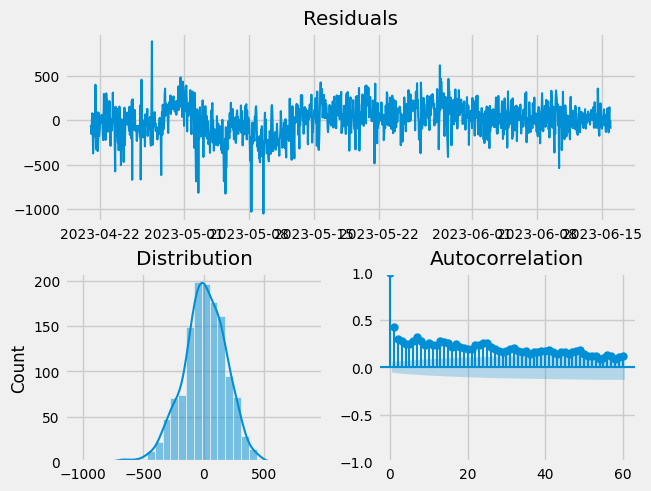

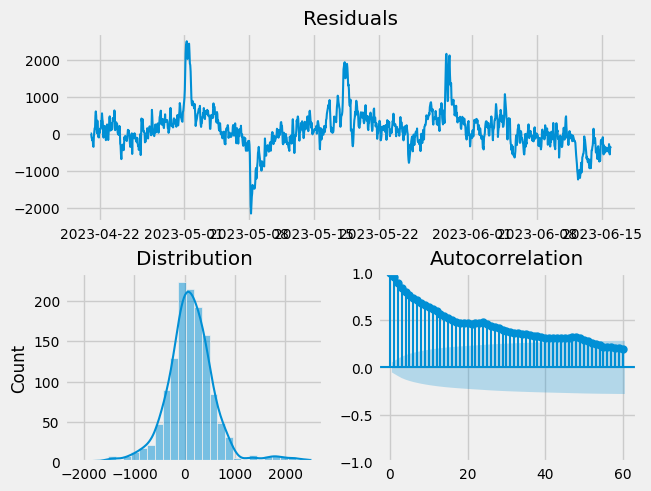

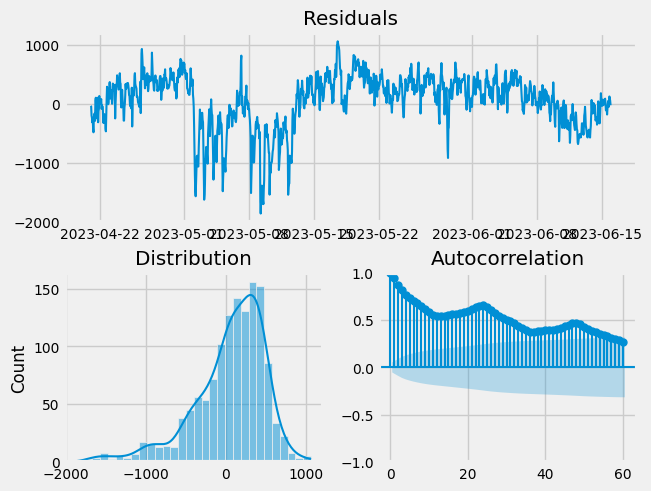

In [ ]:
from skforecast.plot import plot_residuals

for forecast in forecasts_column:
  residuals = data_backtest_result[forecast] - data_test['y']
  plot_residuals(residuals=residuals)

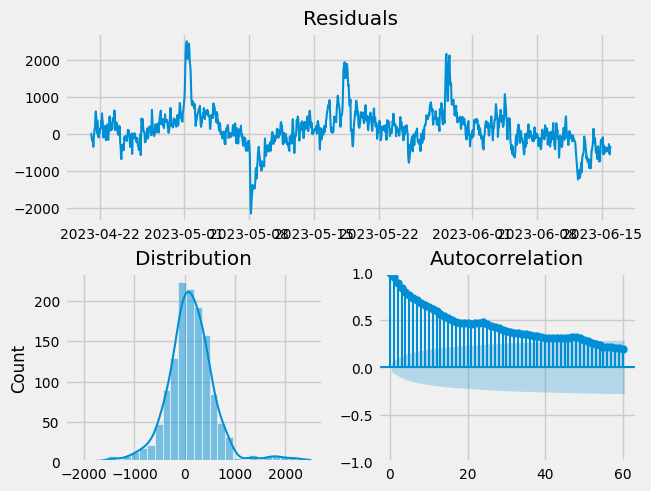

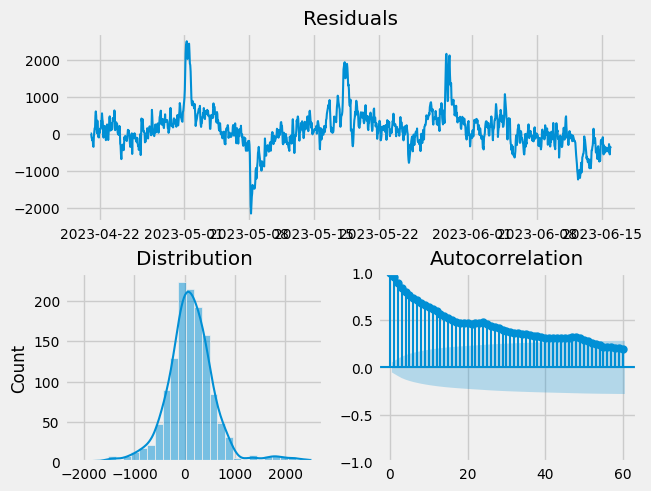

In [ ]:
from skforecast.plot import plot_residuals

residuals = predictions['pred'] - data_test['y']
plot_residuals(residuals=residuals)